In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io.wavfile import read, write
import os
import csv
from pca import compress, decode

In [2]:
img_path = './data/4.jpg'
audio_path = './data/godzilla_roar.wav'
img_save_path = './images/'
audio_save_path = './audios/'
csv_save_path = './compress_rate_result'

In [3]:
os.makedirs(img_save_path, exist_ok=True)
os.makedirs(audio_save_path, exist_ok=True)
os.makedirs(csv_save_path, exist_ok=True)

# Image Compression

In [4]:
def read_img(path):
    img = Image.open(path).convert('L')
    img_arr = np.asarray(img)
    return img_arr

In [5]:
def show_img(arr):
    print(f'Image size: {arr.shape}')
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [6]:
def save_img(arr, k):
    filename = f'k_{k}.jpg'
    path = os.path.join(img_save_path, filename)
    imk = Image.fromarray(arr).convert('L')
    imk.save(path)

In [7]:
def save_csv(k_list, ratio_list, path, filename):
    with open(os.path.join(path, filename), 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(['k', 'compression rate'])
        writer.writerows(zip(k_list, ratio_list))        

In [8]:
k_list = []
k_img_list = []
ratio_list = []

In [9]:
def compress_img(img_arr):
    h, w = img_arr.shape
    for k in range(1, min(h,w), 5):
        U_k, x_mean, Z = compress(img_arr, k)
        Xapprox = decode(U_k, x_mean, Z)
        k_list.append(k)
        k_img_list.append(Xapprox)
        save_img(Xapprox, k)  
    print('Image compression completed !!!')

Image size: (288, 374)


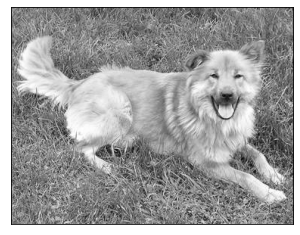

In [10]:
# Show the original image
img_arr = read_img(img_path)
show_img(img_arr)

In [11]:
compress_img(img_arr)

Image compression completed !!!


In [12]:
# Compute ratio
for i in range(len(k_img_list)):
    error = np.linalg.norm(img_arr - k_img_list[i]) / np.linalg.norm(img_arr)
    h, w = img_arr.shape
    k = k_list[i]
    ori_size = h * w
    compressed_size = 4 * (h * k + w + k * w)
    ratio = compressed_size / ori_size
    ratio_list.append(ratio)

In [13]:
# Save to csv
save_csv(k_list, ratio_list, csv_save_path, 'image.csv')

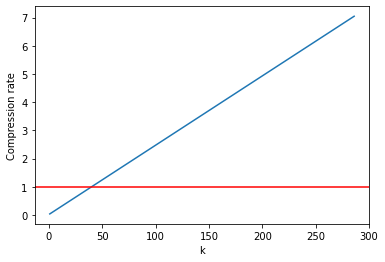

In [14]:
plt.plot(k_list, ratio_list)
plt.axhline(1, 0, 1, color='r')
plt.xlabel('k')
plt.ylabel('Compression rate')
plt.show()

# Audio Compression

In [15]:
def read_audio(path):    
    rate, data = read(path)
    audio_arr = np.array(data, dtype=float) 
    return audio_arr[:, 0], rate

In [16]:
def convert_audio_to_matrix(audio_arr, matrix_size):
    hanging = matrix_size - np.mod(len(audio_arr), matrix_size)
    padded = np.lib.pad(audio_arr, (0, hanging), 'constant', constant_values=0)
    audio_reshaped = padded.reshape((len(padded) // matrix_size, matrix_size))
    return audio_reshaped, len(padded), hanging

In [17]:
def save_audio(k, array, rate):
    filename = f'k_{k}.wav'
    path = os.path.join(audio_save_path, filename)
    write(path, rate, array)

In [18]:
resized = 500
k_list = []
k_audio_list = []
ratio_list = []

In [19]:
def compress_sound(audio_arr, rate):
    audio_reshaped, padded_len, hanging = convert_audio_to_matrix(audio_arr, resized)
    for k in range(1, resized, 10):
        U_k, x_mean, Z = compress(audio_reshaped, k)
        Xapprox = decode(U_k, x_mean, Z)
        Xapprox = Xapprox.reshape((padded_len))
        Xapprox = Xapprox[0:-hanging]
        k_list.append(k)
        k_audio_list.append(Xapprox)
        save_audio(k, Xapprox, rate)
    print('Audio Compression finished !!!')

In [20]:
audio_arr, rate = read_audio(audio_path)
compress_sound(audio_arr, rate)

Audio Compression finished !!!


In [21]:
for i in range(len(k_list)):
    ori_size = 2 * len(audio_arr)
    h, w = (len(audio_arr) // resized + (len(audio_arr) % resized > 0)), resized
    k = k_list[i]
    compressed_size = 4 * (h * k + w + w * k)
    ratio = compressed_size / ori_size
    ratio_list.append(ratio)

In [22]:
# Save to csv
save_csv(k_list, ratio_list, csv_save_path, 'audio.csv')

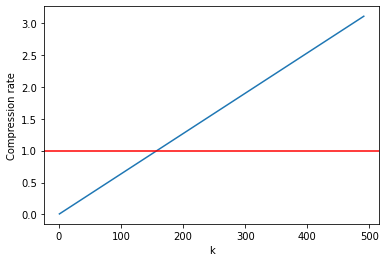

In [23]:
plt.plot(k_list, ratio_list)
plt.axhline(1, 0, 1, color='r')
plt.xlabel('k')
plt.ylabel('Compression rate')
plt.show()